# ImXPAD S540 detector at D2AM

This tutorial corresponds to the calibration the goniometer an ImXPAD detector
composed of 8 stripes of 7 modules, many of which are defective, on a goniometer.

This detector is mounted on the goniometer 2theta arm at the D2AM beam-line, French CRG
at the ESRF synchrotron. 

The raw data files are available at:
http://www.silx.org/pub/pyFAI/gonio/D2AM-15/

In [1]:
%matplotlib inline
#For documentation purpose, `inline` is used to enforce the storage of images into the notebook
# %matplotlib widget
import numpy
from matplotlib.pyplot import subplots

In [2]:
import os, time
start_time = time.perf_counter()
import fabio, pyFAI
print(f"Working with pyFAI version {pyFAI.version}")
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter
from math import ceil

Working with pyFAI version 2025.11.0-dev0


In [3]:
#Download all data
    
from silx.resources import ExternalResources

#Comment out and configure the proxy if you are behind a firewall
#os.environ["http_proxy"] = "http://proxy.company.com:3128"
    
downloader = ExternalResources("pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA")
all_files = downloader.getdir("LaB6_gonio_D2AM.tar.bz2")

print("List of files downloaded:")
for i in all_files:
    print("    "+os.path.basename(i))

detector_file = [i for i in all_files if i.endswith("D5Geom-2018.h5")][0]
images = [i for i in all_files if i.endswith(".edf")]
npt_files = [i for i in all_files if i.endswith(".npt")]

List of files downloaded:
    LaB6_gonio_D2AM
    16Dec08D5_1777-rsz.npt
    16Dec08D5_1791-rsz.npt
    16Dec08D5_1729-rsz.edf
    16Dec08D5_1763-rsz.npt
    D5Geom-2018.h5
    16Dec08D5_1725-rsz.edf
    16Dec08D5_1728-rsz.npt
    16Dec08D5_1784-rsz.npt
    16Dec08D5_1763-rsz.edf
    16Dec08D5_1728-rsz.edf
    16Dec08D5_1735-rsz.npt
    16Dec08D5_1727-rsz.npt
    16Dec08D5_1729-rsz.npt
    16Dec08D5_1770-rsz.edf
    16Dec08D5_1784-rsz.edf
    16Dec08D5_1730-rsz.npt
    16Dec08D5_1742-rsz.npt
    16Dec08D5_1770-rsz.npt
    16Dec08D5_1725-rsz.npt
    16Dec08D5_1726-rsz.npt
    16Dec08D5_1777-rsz.edf
    16Dec08D5_1756-rsz.edf
    16Dec08D5_1735-rsz.edf
    16Dec08D5_1730-rsz.edf
    16Dec08D5_1742-rsz.edf
    16Dec08D5_1791-rsz.edf
    16Dec08D5_1749-rsz.npt
    16Dec08D5_1726-rsz.edf
    16Dec08D5_1756-rsz.npt
    16Dec08D5_1727-rsz.edf
    16Dec08D5_1749-rsz.edf


Detector shape:  (960, 578)
EDF_DataBlockID :  0.Image.Psd
EDF_BinarySize :  4439040
EDF_HeaderSize :  1536
ByteOrder :  LowByteFirst
DataType :  DoubleValue
Dim_1 :  578
Dim_2 :  960
Image :  0
HeaderID :  EH:000000:000000:000000
Size :  4439040
VersionNumber :  1
Epoch :  1481327234.3919599056
det_sample_dist :  0
y_beam :  0
x_beam :  0
Lambda :  0.495938
offset :  0
count_time :  120
point_no :  24
scan_no :  906
preset :  0
col_end :  559
col_beg :  0
row_end :  959
row_beg :  0
counter_pos :  120 2689 156 15.3097 0 90.3692 15.3097 0 25 25 1749 5.65726e+09 0 0 0 174.925 0 0 15.3097
counter_mne :  sec vct1 vct2 vct3 vct4 Imach pseudoC pfoil Emono Ecod img roi1 roi2 roi3 roi4 pico1 pico2 pico3 pico4
motor_pos :  24.0001 0.077502 89.9912 -89.9921 -0.0032 0.0022 57.1197 134.748 -32.9504 0.16656 -5 0.47558 -1.5 0 0 0 4.53604 0.1416 1.04 1.04022 1.04022 -4.4 -1.10211 -0.543725 -9.962 -14.038 -16.865 -7.195 24 -2.038 24.06 4.835 1
motor_mne :  del eta chi phi nu mu keta kap kphi tsx tsy 

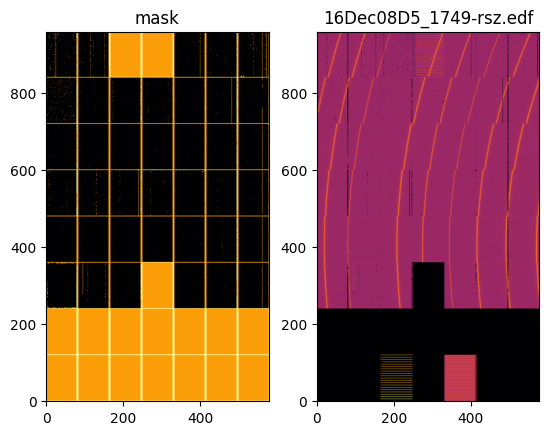

In [4]:
#Definition of the detector and deplay of an image and its mask:

d5 = pyFAI.detector_factory(detector_file)
print("Detector shape: ",d5.shape)

fimg = fabio.open(images[-1])

for k,v in fimg.header.items():
    print(k, ": ", v)
    
f, ax = subplots(1, 2)
jupyter.display(d5.mask, label="mask", ax=ax[0])
jupyter.display(fimg.data, label=os.path.basename(fimg.filename), ax=ax[1]);

In [5]:
# Define wavelength and create our "large" LaB6 calibrant

wavelength = 0.495938 * 1e-10
from pyFAI.calibrant import get_calibrant
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = wavelength
print("2theta max: ", numpy.degrees(LaB6.get_2th()[-1]))
print("Number of reflections: ", len(LaB6.get_2th()))

2theta max:  179.17349767223402
Number of reflections:  236


In [6]:
#Use a few manually calibrated images:

npt_files.sort()
print("Number of hand-calibrated images :",len(npt_files))

Number of hand-calibrated images : 15


In [7]:
# Definition of the goniometer translation function:
# The detector rotates vertically, around the horizontal axis, i.e. rot2. 
# Rotation both around axis 1 and axis 2 are allowed

goniotrans = GeometryTransformation(param_names = ["dist", "poni1", "poni2", 
                                                   "rot1", "rot2", "rot3", "scale1", "scale2" ],
                                    dist_expr="dist", 
                                    poni1_expr="poni1",
                                    poni2_expr="poni2", 
                                    rot1_expr="scale1 * pos +rot1", 
                                    rot2_expr="scale2 * pos + rot2", 
                                    rot3_expr="rot3")


#Definition of the function reading the goniometer angle from the filename of the image.

def get_angle(metadata):
    """Takes the angle from the first motor position and returns the angle of the goniometer arm"""
    return float(metadata["motor_pos"].split()[0])

print('filename', os.path.basename(fimg.filename), "angle:",get_angle(fimg.header))

filename 16Dec08D5_1749-rsz.edf angle: 24.0001


In [8]:
# Definition of the geometry refinement: the parameter order is the same as the param_names

rot3 = numpy.pi/2
scale1 = -numpy.pi/180
scale2 = 0
param = {"dist":0.5, 
         "poni1":0.05, 
         "poni2":0.05, 
         "rot1":0,
         "rot2":0,
         "rot3": rot3,
         "scale1": scale1,
         "scale2": scale2,
        }
#Defines the bounds for some variables
bounds = {"dist": (0.2, 0.8), 
          "poni1": (0, 0.1),
          "poni2": (0, 0.1),
          "rot1": (-0.1, 0.1),
          "rot2": (-0.1, 0.1),
          "rot3": (rot3, rot3), #strict bounds on rot3
          "scale1": (scale1, scale1),
          "scale2": (scale2, scale2),
         }
gonioref = GoniometerRefinement(param, #initial guess
                                bounds=bounds,
                                pos_function=get_angle,
                                trans_function=goniotrans,
                                detector=d5, wavelength=wavelength)
print("Empty refinement object:", gonioref)

#Let's populate the goniometer refinement object with all control point files:

for fn in npt_files[:]:
    base = os.path.splitext(fn)[0]
    fimg = fabio.open(base + ".edf")
    basename = os.path.basename(base)
    sg =gonioref.new_geometry(basename, image=fimg.data, metadata=fimg.header, control_points=fn, calibrant=LaB6)
    print(basename, "Angle:", sg.get_position())
    

print("Filled refinement object:")
print(gonioref)

Empty refinement object: GoniometerRefinement with 0 geometries labeled: .
16Dec08D5_1725-rsz Angle: -0.003
16Dec08D5_1726-rsz Angle: 0.9998
16Dec08D5_1727-rsz Angle: 2.0
16Dec08D5_1728-rsz Angle: 2.9998
16Dec08D5_1729-rsz Angle: 4.0002
16Dec08D5_1730-rsz Angle: 4.9998
16Dec08D5_1735-rsz Angle: 10.0001
16Dec08D5_1742-rsz Angle: 16.9996
16Dec08D5_1749-rsz Angle: 24.0001
16Dec08D5_1756-rsz Angle: 30.9997
16Dec08D5_1763-rsz Angle: 37.9999
16Dec08D5_1770-rsz Angle: 44.9997
16Dec08D5_1777-rsz Angle: 52.0
16Dec08D5_1784-rsz Angle: 58.9995
16Dec08D5_1791-rsz Angle: 65.9999
Filled refinement object:
GoniometerRefinement with 15 geometries labeled: 16Dec08D5_1725-rsz, 16Dec08D5_1726-rsz, 16Dec08D5_1727-rsz, 16Dec08D5_1728-rsz, 16Dec08D5_1729-rsz, 16Dec08D5_1730-rsz, 16Dec08D5_1735-rsz, 16Dec08D5_1742-rsz, 16Dec08D5_1749-rsz, 16Dec08D5_1756-rsz, 16Dec08D5_1763-rsz, 16Dec08D5_1770-rsz, 16Dec08D5_1777-rsz, 16Dec08D5_1784-rsz, 16Dec08D5_1791-rsz.


In [9]:
# Initial refinement of the goniometer model with 5 dof

gonioref.refine3()

Free parameters: ['dist', 'poni1', 'poni2', 'rot1', 'rot2']
Fixed: {'rot3': 1.5707963267948966, 'scale1': -0.017453292519943295, 'scale2': 0}
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.469091857685446e-07
       x: [ 5.225e-01  8.731e-02  4.574e-02  3.270e-03 -3.865e-02]
     nit: 25
     jac: [ 2.242e-08  5.022e-08 -2.136e-07 -1.038e-07  2.675e-08]
    nfev: 151
    njev: 25
Constrained Least square 0.0003076612160235168 --> 3.469091857685446e-07
maxdelta on rot2: 0.0 --> -0.038647906477604826 


np.float64(3.469091857685446e-07)

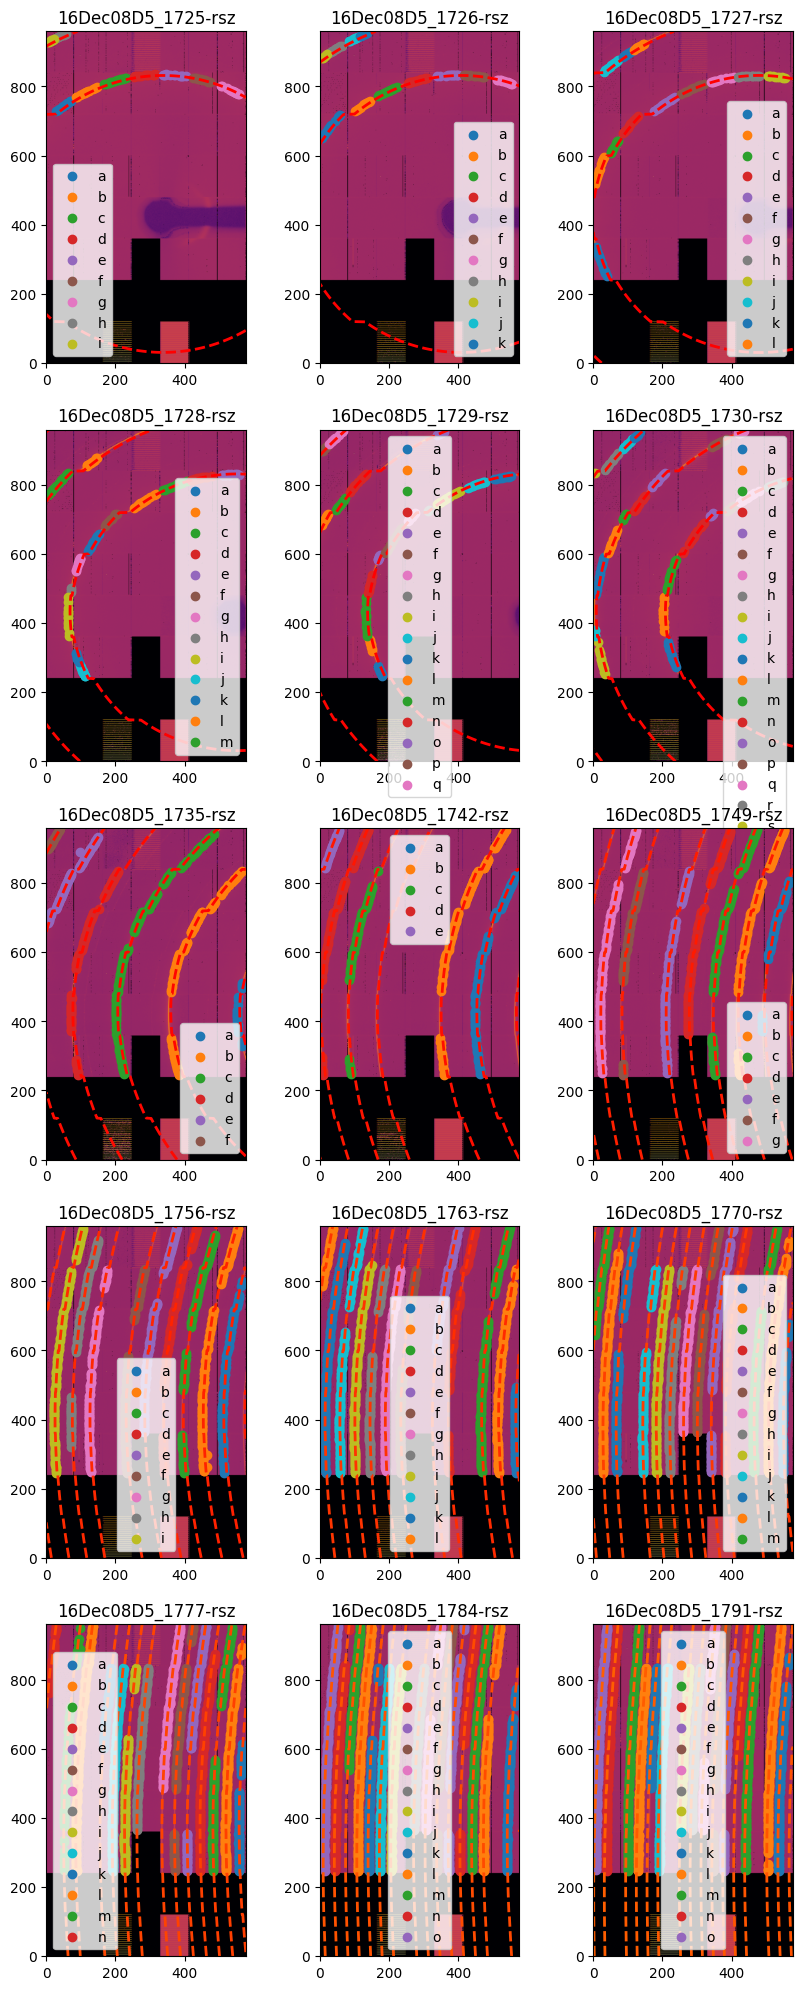

In [10]:
width = 3
height = int(ceil(len(gonioref.single_geometries) / width))
fig,ax = subplots(height, width,figsize=(10, 25))
for idx, sg in enumerate(gonioref.single_geometries.values()):
    sg.geometry_refinement.set_param(gonioref.get_ai(sg.get_position()).param)
    jupyter.display(sg=sg, ax=ax[idx//width, idx%width]);

In [11]:
# Final pass of refinement with all constrains removed, very fine refinement

gonioref.bounds = None
gonioref.refine3(fix=["rot3"], method="slsqp", eps=1e-13, maxiter=10000, ftol=1e-12)
gonioref.refine3(fix=["rot3"], method="simplex", maxiter=10000, ftol=1e-12)

Free parameters: ['dist', 'poni1', 'poni2', 'rot1', 'rot2', 'scale1', 'scale2']
Fixed: {'rot3': 1.5707963267948966}


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.8635168303377307e-07
       x: [ 5.217e-01  8.731e-02  4.574e-02  4.502e-03 -3.883e-02
           -1.748e-02 -4.287e-05]
     nit: 12
     jac: [ 2.302e-08  0.000e+00  0.000e+00 -5.585e-08 -4.261e-08
           -3.193e-06  5.559e-09]
    nfev: 102
    njev: 12
Constrained Least square 3.469091857685446e-07 --> 1.8635168303377307e-07
maxdelta on rot1: 0.0032695600972333276 --> 0.004501522906845148 
Free parameters: ['dist', 'poni1', 'poni2', 'rot1', 'rot2', 'scale1', 'scale2']
Fixed: {'rot3': 1.5707963267948966}


/users/kieffer/.venv/py313/lib/python3.13/site-packages/pyFAI/goniometer.py:1001: OptimizeWarning: Unknown solver options: ftol
  res = minimize(self.residu3, param, method=method,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.3894090408467174e-08
             x: [ 5.201e-01  5.793e-02  4.099e-02 -3.782e-03  1.827e-02
                 -1.747e-02 -4.648e-04]
           nit: 633
          nfev: 1126
 final_simplex: (array([[ 5.201e-01,  5.793e-02, ..., -1.747e-02,
                        -4.648e-04],
                       [ 5.201e-01,  5.793e-02, ..., -1.747e-02,
                        -4.648e-04],
                       ...,
                       [ 5.201e-01,  5.793e-02, ..., -1.747e-02,
                        -4.648e-04],
                       [ 5.201e-01,  5.793e-02, ..., -1.747e-02,
                        -4.648e-04]], shape=(8, 7)), array([ 1.389e-08,  1.389e-08,  1.389e-08,  1.389e-08,
                        1.389e-08,  1.389e-08,  1.389e-08,  1.389e-08]))
Constrained Least square 1.8635168303377307e-07 --> 1.3894090408467174e-08
maxdelta on rot2: -0.03882584899486354 --> 0.01826576174612

np.float64(1.3894090408467174e-08)

In [12]:
#Create a MultiGeometry integrator from the refined geometry:

angles = []
images = []
for sg in gonioref.single_geometries.values():
    angles.append(sg.get_position())
    images.append(sg.image)
    
multigeo = gonioref.get_mg(angles)
multigeo.radial_range=(0, 80)
print(multigeo)

MultiGeometry integrator with 15 geometries on (0, 80) radial range ((2th_deg, chi_deg)) and (-180, 180) azimuthal range (deg)


<Axes: title={'center': '1D integration'}, xlabel='Scattering angle $2\\theta$ ($^{o}$)', ylabel='Intensity'>

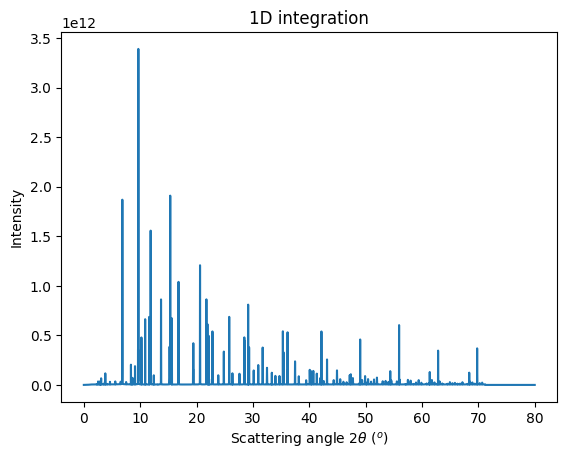

In [13]:
# Integrate the whole set of images in a single run:

res = multigeo.integrate1d(images, 10000)
jupyter.plot1d(res)

#Note the large number of peaks due to hot pixels ....

In [14]:
#Add hot pixels to the mask: pixel which are 15x more intense than the median in their ring.

thres = 15

old_mask = d5.mask.astype("bool", copy=True)
new_mask = d5.mask.astype("bool", copy=True)

for ai,img in zip(multigeo.ais,images):
    b,a = ai.separate(img, 1000, restore_mask=0)
    b[old_mask] = 0
    b[b<0] = 0
    # print(sum(b>thres*a))
    new_mask = numpy.logical_or(new_mask, (b>thres*a))

print(#" Size of old mask", sum(old_mask), 
      #" Size of new mask",sum(new_mask), 
      " Number of pixel discarded", sum(new_mask)-sum(old_mask))

    

 Number of pixel discarded [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

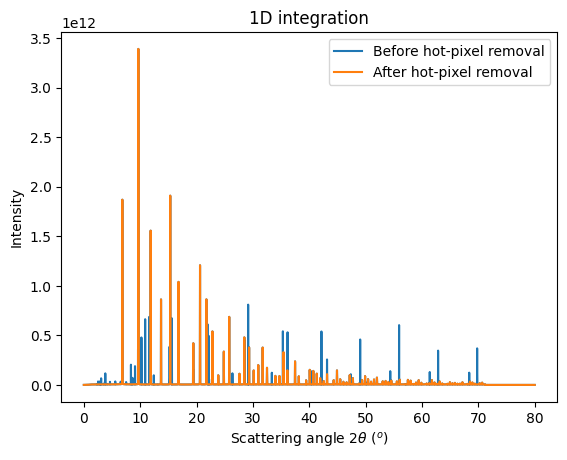

In [15]:
# Update the mask
for ai in multigeo.ais:
    ai.detector.mask = new_mask
    
# Integrate the whole set of images in a single run:
res2 = multigeo.integrate1d(images, 10000)
ax = jupyter.plot1d(res, label="Before hot-pixel removal")
ax.plot(*res2, label="After hot-pixel removal")
ax.legend();

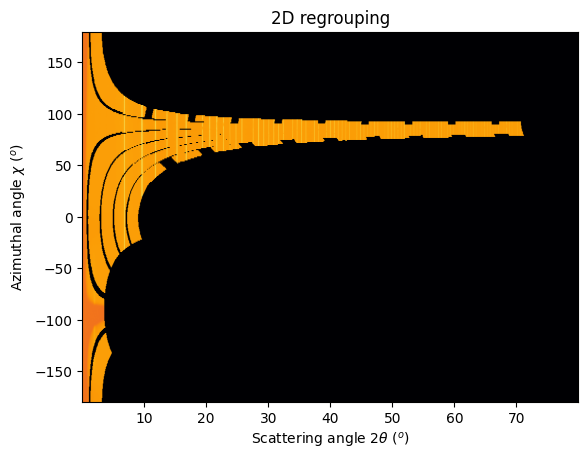

In [16]:
# Integrate the whole set of images in 2D:

res2d = multigeo.integrate2d(images, 1000, 360)
jupyter.plot2d(res2d);

In [17]:
print(f"Total execution time {time.perf_counter()-start_time:.3f} s")

Total execution time 165.853 s
